# STT

In [15]:
!pip install vosk


In [3]:
import os
import sys
import wave
import json
from vosk import Model, KaldiRecognizer


In [4]:
model_path = "./model/vosk-model-small-fr-0.22"

# Chargement du modèle
if not os.path.exists(model_path):
    print("Le modèle n'existe pas. Téléchargez-le à partir de https://alphacephei.com/vosk/models")
    sys.exit(1)

model = Model(model_path)

LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=15 max-active=7000 lattice-beam=5
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 0 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 0 orphan components.
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from ./model/vosk-model-small-fr-0.22/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from ./model/vosk-model-small-fr-0.22/graph/HCLr.fst ./model/vosk-model-small-fr-0.22/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo ./model/vosk-model-small-fr-0.22/graph/phones/word_boundary.int


In [5]:
def recognize_audio(usedModel,filename):
    wf = wave.open(filename, "rb")
    rec = KaldiRecognizer(usedModel, wf.getframerate())

    # Lire le fichier audio et effectuer la reconnaissance
    results = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if rec.AcceptWaveform(data):
            result = rec.Result()
            results.append(result)
        else:
            rec.PartialResult()

    # Récupérer le résultat final
    final_result = rec.FinalResult()
    results.append(final_result)
    
    # Afficher tous les résultats
    for result in results:
        print(result)


In [6]:
recognize_audio(model,"./data/audio/data_2.wav")

{
  "text" : "donne-moi le chemin le plus court pour aller de paris à lyon"
}


# PATHFINDING

In [32]:
!pip install networkx pandas matplotlib scipy

  Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached scipy-1.14.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (40.8 MB)


In [30]:
import heapq
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
df = pd.read_csv('./data/timetables.csv',sep=';')
print(df.head())
# Créer un graphe
graph = nx.DiGraph()

# Ajouter des arêtes au graphe
for index, row in df.iterrows():
    trajet = row['trajet']
    duree = row['duree']
    segments = trajet.split(' - ')
    if len(segments) >= 2:
        # Calculer le poids par segment
        poids_par_segment = duree / (len(segments) - 1)
        
        for i in range(len(segments) - 1):
            depart = segments[i].strip()  # Retirer les espaces
            destination = segments[i + 1].strip()
            graph.add_edge(depart, destination, weight=poids_par_segment)
    else:
        print(f"Erreur dans le trajet: {trajet}")

# Afficher le nombre de nœuds et d'arêtes
print(f'Nombre de nœuds : {graph.number_of_nodes()}')
print(f'Nombre d\'arêtes : {graph.number_of_edges()}')


                 trip_id                                             trajet  \
0  OCESN003100F140147152         Gare de Le Havre - Gare de Paris-St-Lazare   
1  OCESN003190F040047309           Gare de Dieppe - Gare de Paris-St-Lazare   
2  OCESN003198F030037315  Gare de Paris-St-Lazare - Gare de Rouen-Rive-D...   
3  OCESN003300F030037323        Gare de Cherbourg - Gare de Paris-St-Lazare   
4  OCESN003313F380387526             Gare de Caen - Gare de Paris-St-Lazare   

   duree  
0    138  
1    145  
2     97  
3    194  
4    149  
Nombre de nœuds : 819
Nombre d'arêtes : 1581


In [25]:
def heuristique(ville_actuelle, ville_destination):
    return 0 

In [43]:
def a_star(graph, start, goal):
    # Priority queue pour les nœuds à explorer
    queue = [(0, start)]
    # Dictionnaire pour suivre les coûts
    costs = {start: 0}
    # Dictionnaire pour suivre les chemins
    came_from = {start: None}
    
    while queue:
        current_cost, current_node = heapq.heappop(queue)
        
        if current_node == goal:
            # Reconstruire le chemin
            path = []
            total_duration = 0
            while current_node is not None:
                path.append(current_node)
                current_node = came_from[current_node]
            path.reverse()
            
            # Calculer la durée totale du chemin
            for i in range(len(path) - 1):
                total_duration += graph[path[i]][path[i + 1]]['weight']
                
            return path, total_duration

        # Explorer les voisins
        for neighbor in graph[current_node]:
            new_cost = costs[current_node] + graph[current_node][neighbor]['weight']
            if neighbor not in costs or new_cost < costs[neighbor]:
                costs[neighbor] = new_cost
                priority = new_cost  # Vous pouvez ajuster la priorité avec une heuristique
                heapq.heappush(queue, (priority, neighbor))
                came_from[neighbor] = current_node

    return None, None  # Si aucun chemin n'est trouvé

In [45]:

# Exemple d'utilisation
start_station = "Gare de Lille Flandres"
goal_station = "Gare de Marseille-St-Charles"
path, total_duration = a_star(graph, start_station, goal_station)
if path:
    print(f"Le chemin optimal de {start_station} à {goal_station} est : {' -> '.join(path)}")
    print(f"Durée totale : {total_duration} min")
else:
    print(f"Aucun chemin trouvé de {start_station} à {goal_station}.")

Aucun chemin trouvé de Gare de Lille Flandres à Gare de Marseille-St-Charles.


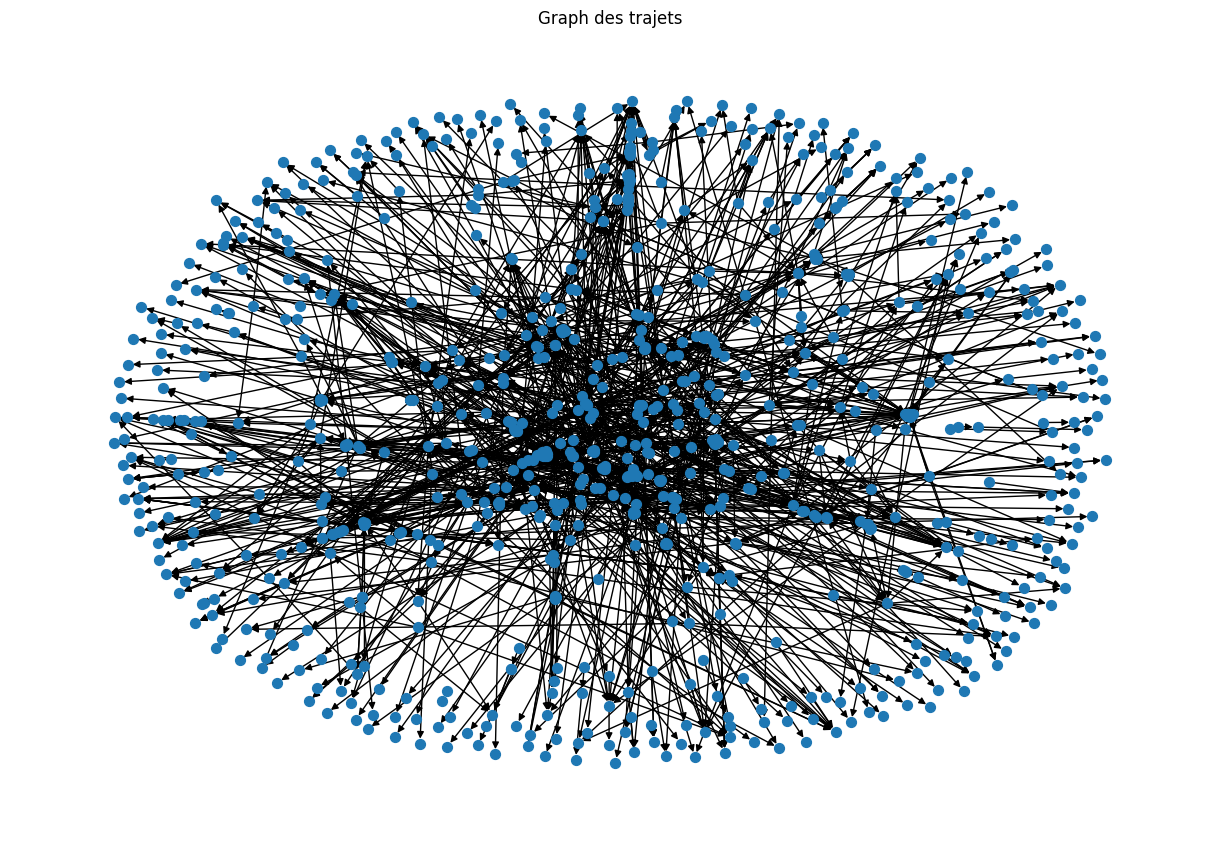

In [40]:
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(graph)
nx.draw(graph, pos, with_labels=False, node_size=50)
plt.title("Graph des trajets")
plt.show()